In [71]:
%matplotlib inline

import os
import h5py
import numpy as np
from scipy.signal import detrend, butter, filtfilt
from obspy import UTCDateTime
from obspy.signal.trigger import recursive_sta_lta
from pyproj import Proj
import matplotlib.pyplot as plt

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

### Compare tap test channel geometry with acoustic moveout

In [2]:
fdir = '/1-fnp/petasaur/p-wd05/harper_plots'
flist = np.array(os.listdir(fdir))

fname2datetime = lambda fn: UTCDateTime.strptime(fn,format='%Y-%m-%d_%H.%M.%S')

ftime = np.array([fname2datetime('_'.join(fname.split('_')[1:3])) for fname in flist])
index = np.argsort(np.array(ftime)-ftime[0])
flist = flist[index]
ftime = ftime[index]

In [161]:
# Load data and remove mean

ind = 1020
fpath = os.path.join(fdir,flist[ind])

with h5py.File(fpath,'r') as fp:
    fs = fp['Acquisition']['Raw[0]'].attrs['OutputDataRate']
    dx = fp['Acquisition'].attrs['SpatialSamplingInterval']
    nx = fp['Acquisition']['Raw[0]'].attrs['NumberOfLoci']
    ns = len(fp['Acquisition']['Raw[0]']['RawDataTime'][:])
    data = fp['Acquisition']['Raw[0]']['RawData'][:]
    data -= np.tile(np.mean(data,axis=0),(ns,1))

In [177]:
# Filter data

fmin = 100
fmax = 500

b,a = butter(4,(fmin,fmax),fs=fs,btype='bandpass')
filt = filtfilt(b,a,data,axis=0)

(27.0, 162.0)

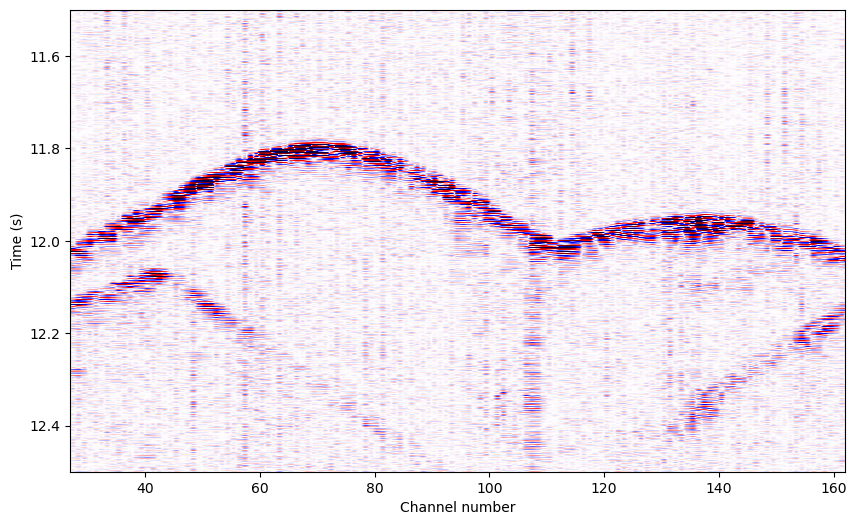

In [178]:
xlim = [27,162]
ylim = [12.5,11.5]
clim = 0.5

plt.figure(figsize=(10,6))
plt.imshow(filt,aspect='auto',cmap='seismic',extent=[0,nx,ns/fs,0],vmin=-clim,vmax=clim)
plt.xlabel('Channel number')
plt.ylabel('Time (s)')
plt.ylim(ylim)
plt.xlim(xlim)

In [185]:
# Get moveout curve
val = 10
sta = int(0.01*fs)
lta = int(1*fs)
t0 = np.zeros(nx)
t = np.arange(ns)/fs
idt1 = np.logical_and(t>=0,t<=13)
idt2 = np.logical_and(t[idt1]>=11.78,t[idt1]<=12.2)
for ix in range(nx):
    trig = recursive_sta_lta(filt[idt1,ix],sta,lta)
    thres = np.argwhere(np.diff(trig[idt2]>val,prepend=False))
    if len(thres) == 0:
        t0[ix] = np.nan
    else:
        t0[ix] = t[idt1][idt2][thres[0]]

(27.0, 162.0)

<Figure size 640x480 with 0 Axes>

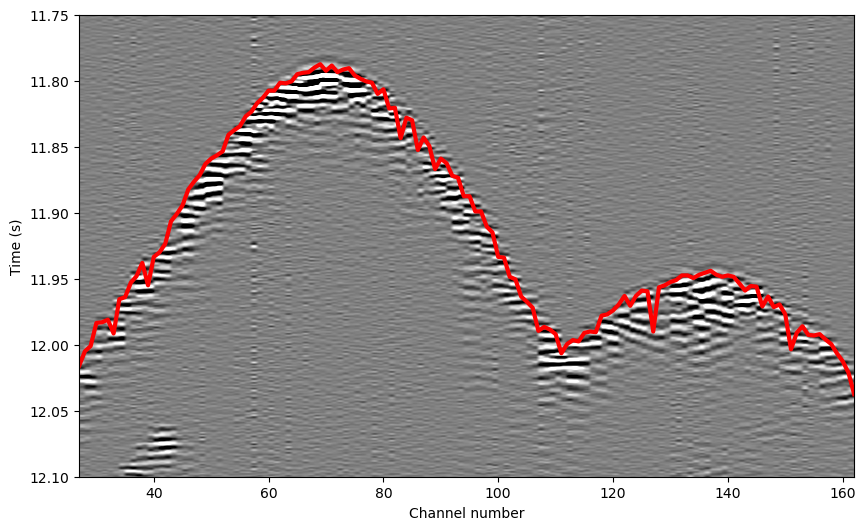

In [186]:
ch = np.arange(27,163)
t0x = t0[27:163]

plt.figure()

xlim = [27,162]
ylim = [12.1,11.75]
clim = 0.5

plt.figure(figsize=(10,6))
plt.imshow(filt,aspect='auto',cmap='gray',extent=[0,nx,ns/fs,0],vmin=-clim,vmax=clim)
plt.plot(ch,t0x,'r',linewidth=3)
plt.xlabel('Channel number')
plt.ylabel('Time (s)')
plt.ylim(ylim)
plt.xlim(xlim)

In [173]:
# Load geometry from tap test

tmp = np.genfromtxt('harper_fiberroute_v1.csv',delimiter=',',skip_header=2)
lat1 = tmp[:,0]
lon1 = tmp[:,1]
cnum = tmp[:,2]

tmp = np.genfromtxt('harper_fiberroute_v2.csv',delimiter=',',skip_header=2)
lat2 = tmp[:,0]
lon2 = tmp[:,1]

In [176]:
# Convert to northing and easting

myProj = Proj("+proj=utm +zone=29 +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

x1,y1 = myProj(lon1,lat1)
x2,y2 = myProj(lon2,lat2)

(27.0, 162.0)

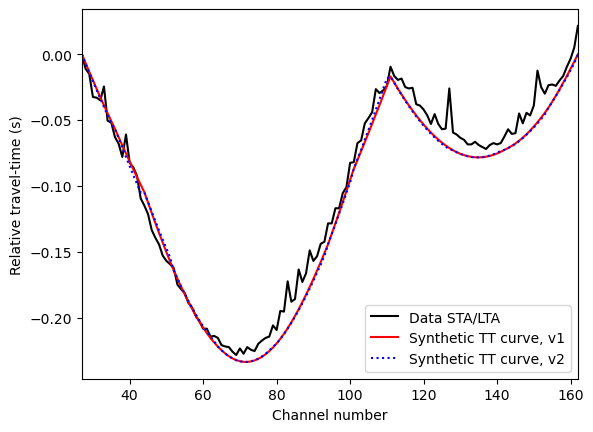

In [231]:
# Create synthetic traveltime curves

dx1 = x1 - x1[0]
dy1 = y1 - y1[0]
dx2 = x2 - x2[0]
dy2 = y2 - y2[0]

v = 330
r = 150
a = 41
ddt1 = (1./v) * (np.sqrt((dx1-r*np.cos(a))**2 + (dy1-r*np.sin(a))**2) - r)
ddt2 = (1./v) * (np.sqrt((dx2-r*np.cos(a))**2 + (dy2-r*np.sin(a))**2) - r)

plt.figure()
plt.plot(ch,dt,'k',label='Data STA/LTA')
plt.plot(ch,ddt1,'r',label='Synthetic TT curve, v1')
plt.plot(ch,ddt2,'b:',label='Synthetic TT curve, v2')
plt.xlabel('Channel number')
plt.ylabel('Relative travel-time (s)')
plt.legend(loc='lower right')
plt.xlim(xlim)